In [3]:
from mps_motion_tracking import motion_tracking as mt
from mps_motion_tracking import Mechancis
import mps
from pathlib import Path

In [4]:
path = Path("PointH4A_ChannelBF_VC_Seq0018.nd2")
data = mps.MPS(path)

2021-01-21 14:35:51,667 - mps.load - INFO - Load nd2 file /Users/henriknf/local/src/mps_motion_tracking/demo/PointH4A_ChannelBF_VC_Seq0018.nd2
INFO:mps.load:Load nd2 file /Users/henriknf/local/src/mps_motion_tracking/demo/PointH4A_ChannelBF_VC_Seq0018.nd2
2021-01-21 14:35:53,951 - mps.load - INFO - Loaded 267 frames in 2.2828660011291504 seconds
INFO:mps.load:Loaded 267 frames in 2.2828660011291504 seconds


In [5]:
motion = mt.DenseOpticalFlow(data)
disp = motion.get_displacements(scale=0.5)

Resize frames from (2044, 1174) to (1022, 587): 100%|██████████| 267/267 [00:10<00:00, 26.12it/s]
INFO:mps_motion_tracking.farneback:Get displacements using Farneback's algorithm
Compute optical flow: 100%|██████████| 267/267 [00:23<00:00, 11.39it/s]


In [6]:
import matplotlib.pyplot as plt
import numpy as np
d = disp * data.info["um_per_pixel"]
np.save("disp.npy", d)
d = np.load("disp.npy")

In [7]:
m = Mechancis(d)
m.u

INFO:mps_motion_tracking.mechanics:Convert displacement to dask array


dask.array<array, shape=(267, 1022, 587, 2), dtype=float64, chunksize=(203, 146, 203, 2), chunktype=numpy.ndarray>

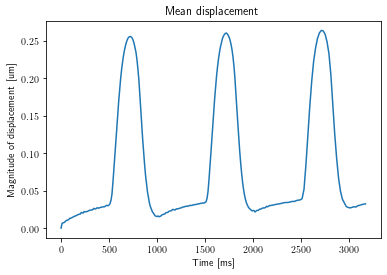

In [8]:
fig, ax = plt.subplots()
ax.plot(data.time_stamps, m.u_mean_norm.compute())
ax.set_title("Mean displacement")
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Magnitude of displacement [um]")
plt.show()

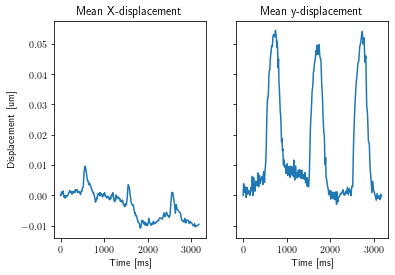

In [9]:

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].plot(data.time_stamps, m.u_mean(axis=0).compute())
ax[0].set_title("Mean X-displacement")
ax[0].set_xlabel("Time [ms]")
ax[0].set_ylabel("Displacement [um]")

ax[1].plot(data.time_stamps, m.u_mean(axis=1).compute())
ax[1].set_title("Mean y-displacement")
ax[1].set_xlabel("Time [ms]")
plt.show()

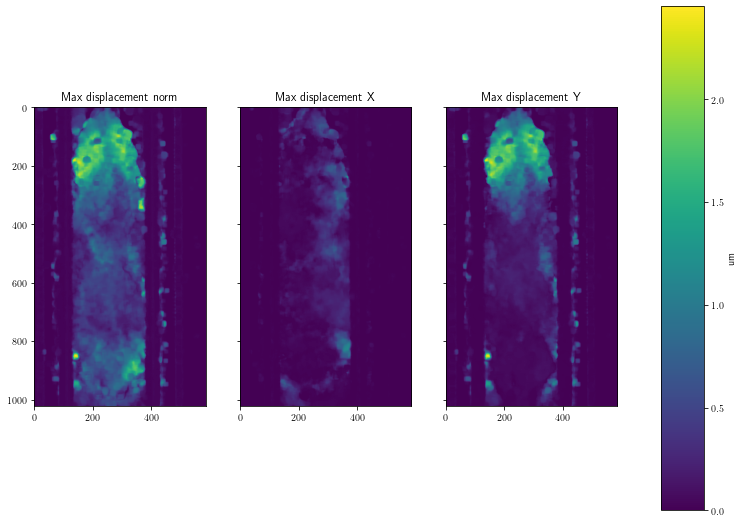

In [10]:
max_disp_x = m.u[..., 0].max(0)
max_disp_y = m.u[..., 1].max(0)
max_disp = m.u_norm.max(0)

vmin = 0
vmax = max_disp.max()
fig, ax = plt.subplots(1, 3, figsize=(12,10), sharex=True, sharey=True)
# Norm
ax[0].imshow(max_disp, vmin=vmin, vmax=vmax)
ax[0].set_title("Max displacement norm")
# X
ax[1].imshow(max_disp_x, vmin=vmin, vmax=vmax)
ax[1].set_title("Max displacement X")
# Y
im = ax[2].imshow(max_disp_y, vmin=vmin, vmax=vmax)

ax[2].set_title("Max displacement Y")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("um")

plt.show()

In [11]:
e1 = m.principal_strain()

INFO:mps_motion_tracking.mechanics:Compute gradient
INFO:mps_motion_tracking.mechanics:Compute Green Lagrange strain
INFO:mps_motion_tracking.mechanics:Compute principal values
INFO:mps_motion_tracking.mechanics:Compute dask array
INFO:mps_motion_tracking.mechanics:Computed dask array in 16.500 seconds
INFO:mps_motion_tracking.mechanics:Princical values computed in 43.244 seconds


In [12]:
e2 = m.principal_strain(1)

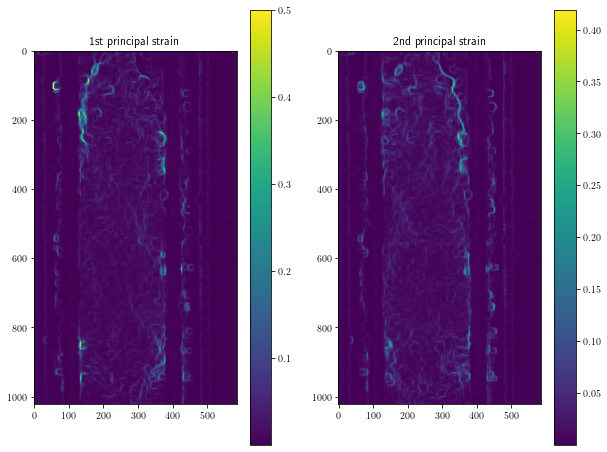

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
im1 = ax[0].imshow(np.abs(e1).max(0), vmax=0.5)
cbar1 = fig.colorbar(im1, ax=ax[0])
im2 = ax[1].imshow(np.abs(e2).max(0))
cbar2 = fig.colorbar(im2, ax=ax[1])
ax[0].set_title("1st principal strain")
ax[1].set_title("2nd principal strain")
plt.show()

<IPython.core.display.Javascript object>


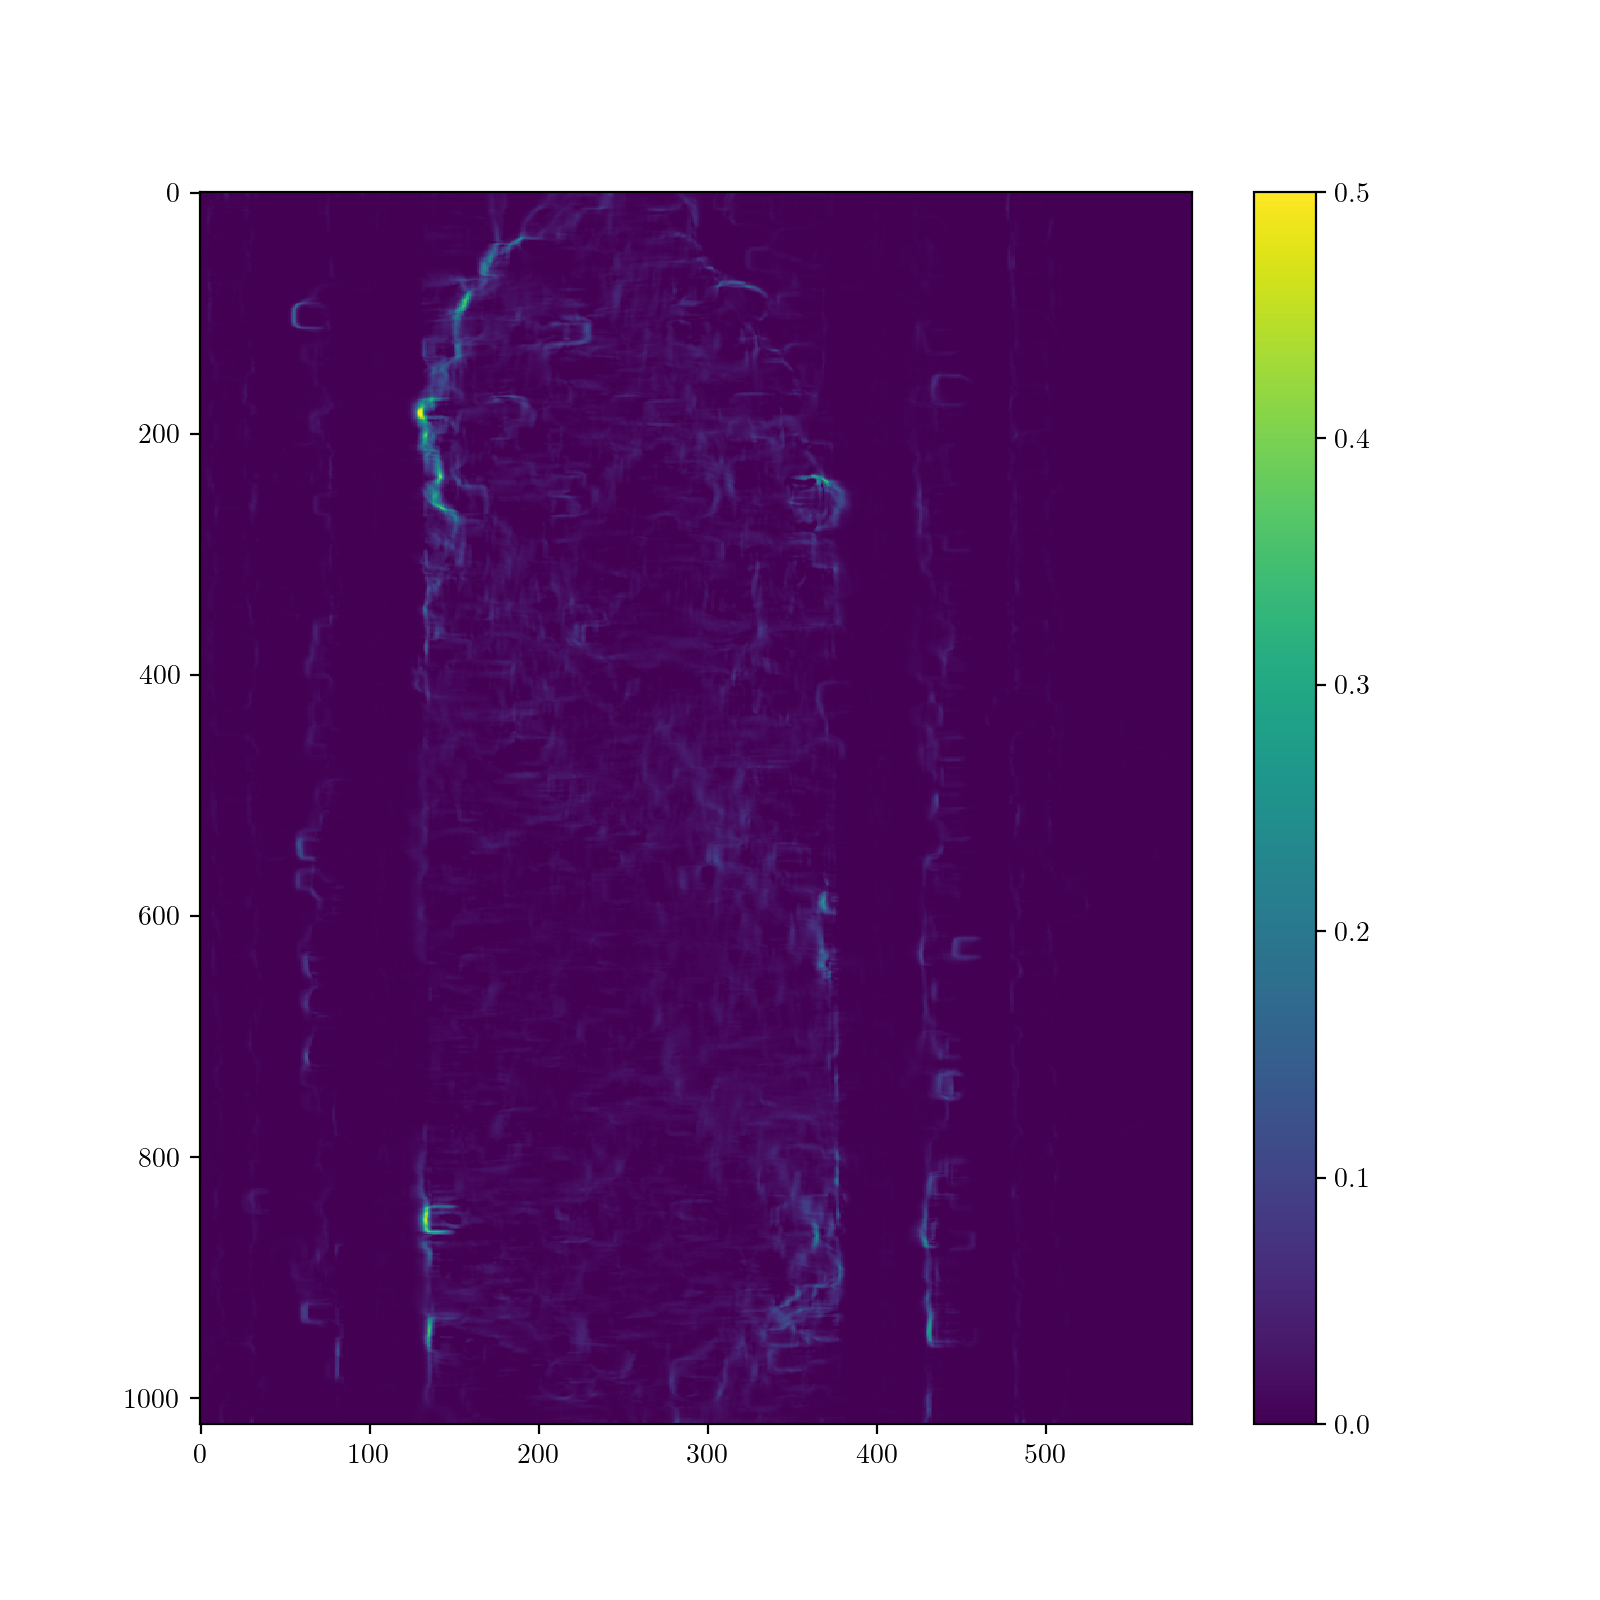

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 800x800 -pix_fmt rgba -r 84 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y test_anim.mp4


Done!


In [18]:
%matplotlib notebook

import random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8,8))

im = plt.imshow(e1[0], interpolation='none', aspect='auto', vmin=0, vmax=0.5)
cbar = fig.colorbar(im)

def animate_func(i):
    im.set_array(e1[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = e1.shape[0],
                               )

writer = animation.writers["ffmpeg"](fps=data.framerate)
anim.save('test_anim.mp4', writer=writer)

print('Done!')